# OmniGlue - Feature Matching with Foundation Model Guidance

This notebook will help you set up and test the OmniGlue library from Google Research, which is designed for generalizable image feature matching using foundation model guidance.

OmniGlue was introduced in a CVPR 2024 paper as a solution for image matching that can better generalize to novel image domains not seen during training.

## 1. Environment Setup

First, let's set up the environment by installing the necessary packages. We'll create a conda environment, clone the repository, and install the required dependencies.

In [1]:
# Install OmniGlue and its dependencies
!git clone https://github.com/google-research/omniglue.git
%cd omniglue
!pip install -e .

fatal: destination path 'omniglue' already exists and is not an empty directory.
/mnt/sagemaker-nvme/omniglue-triton/omniglue
Obtaining file:///mnt/sagemaker-nvme/omniglue-triton/omniglue
  Installing build dependencies ... one
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for omniglue (pyproject.toml) ... done
  Created wheel for omniglue: filename=omniglue-0.0.0-0.editable-py3-none-any.whl size=13387 sha256=04f02f93a4e146cc5d37d2532ade6ddce80c40006541d0284b7cb656cd186626
  Stored in directory: /tmp/pip-ephem-wheel-cache-p5b7xj3z/wheels/ed/50/5f/43084c321c2a6b5983758a39681b835d591449232d87e44b8b
Successfully built omniglue
  Attempting uninstall: omniglue
    Found existing installation: omniglue 0.0.0
    Uninstalling omniglue-0.0.0:
      Successfully uninstalled omniglue-0.0.0


## 2. Download Required Models

OmniGlue requires multiple pre-trained models to work properly:
1. SuperPoint - For keypoint detection
2. DINOv2 - A vision foundation model (vit-b14)
3. OmniGlue weights - The trained OmniGlue model

In [2]:
# Create models directory
!mkdir -p models
%cd models

/mnt/sagemaker-nvme/omniglue-triton/omniglue/models


In [3]:
# Download SuperPoint
!git clone https://github.com/rpautrat/SuperPoint.git
!mv SuperPoint/pretrained_models/sp_v6.tgz .
!rm -rf SuperPoint
!tar zxvf sp_v6.tgz
!rm sp_v6.tgz

Cloning into 'SuperPoint'...
remote: Enumerating objects: 1611, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 1611 (delta 13), reused 18 (delta 7), pack-reused 1575 (from 1)
Receiving objects: 100% (1611/1611), 549.39 MiB | 49.82 MiB/s, done.
Resolving deltas: 100% (1078/1078), done.
Updating files: 100% (83/83), done.
sp_v6/
sp_v6/saved_model.pb
sp_v6/variables/
sp_v6/variables/variables.index
sp_v6/variables/variables.data-00000-of-00001


In [4]:
# Download DINOv2 (vit-b14)
!wget https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth

--2025-03-26 06:07:29--  https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.24.93, 3.163.24.72, 3.163.24.87, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.24.93|:443... connected.
200 OKequest sent, awaiting response... 
Length: 346378731 (330M) [binary/octet-stream]
Saving to: ‘dinov2_vitb14_pretrain.pth.4’

dinov2_vitb14_pretr 100%[===================>] 330.33M   273MB/s    in 1.2s    

2025-03-26 06:07:31 (273 MB/s) - ‘dinov2_vitb14_pretrain.pth.4’ saved [346378731/346378731]



In [5]:
# Download OmniGlue weights
!wget https://storage.googleapis.com/omniglue/og_export.zip
!unzip og_export.zip
!rm og_export.zip

--2025-03-26 06:07:31--  https://storage.googleapis.com/omniglue/og_export.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.215.251, 172.217.14.219, 142.250.69.219, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.215.251|:443... connected.
200 OKequest sent, awaiting response... 
Length: 45860170 (44M) [application/zip]
Saving to: ‘og_export.zip’

og_export.zip       100%[===================>]  43.74M   174MB/s    in 0.3s    

2025-03-26 06:07:31 (174 MB/s) - ‘og_export.zip’ saved [45860170/45860170]

Archive:  og_export.zip
^Cplace og_export/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 


In [6]:
# Go back to the main directory
%cd ..

/mnt/sagemaker-nvme/omniglue-triton/omniglue


## 3. Import Libraries

Now let's import the required libraries for testing OmniGlue.

In [7]:
# First, let's check if we can import omniglue and debug any issues
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import time

# Print Python path to help with debugging
print("Python path:")
for path in sys.path:
    print(f"  - {path}")

# Try to import omniglue with error handling
try:
    import omniglue
    from omniglue import utils
    print("Successfully imported omniglue!")
except ImportError as e:
    print(f"Error importing omniglue: {e}")
    print("\nTroubleshooting steps:")
    print("1. Make sure you're in the right directory")
    print("2. Check if the package was installed correctly")
    print("3. Try reinstalling:")
    print("   !pip install -e . --verbose")
    print("4. Check if the package is in your path:")
    print("   !pip list | grep omni")
    # Add the repository directory to path as a fallback
    current_dir = os.getcwd()
    if current_dir not in sys.path:
        print(f"Adding current directory to Python path: {current_dir}")
        sys.path.append(current_dir)
        try:
            import omniglue
            from omniglue import utils
            print("Successfully imported omniglue after adding current directory to path!")
        except ImportError as e:
            print(f"Still cannot import omniglue: {e}")
            print("You may need to restart the kernel after installation.")

Python path:
  - /opt/conda/lib/python311.zip
  - /opt/conda/lib/python3.11
  - /opt/conda/lib/python3.11/lib-dynload
  - 
  - /opt/conda/lib/python3.11/site-packages


2025-03-26 06:07:40.187514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-26 06:07:40.203401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-26 06:07:40.208387: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-26 06:07:40.220339: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Successfully imported omniglue!


## 4. Download Test Images

Let's download some sample images to test OmniGlue or use the demo images from the repository.

In [8]:
# Check if demo images exist in the repo
!ls -la res/

total 6364
drwxr-xr-x  2 sagemaker-user users      85 Mar 25 18:45 .
drwxr-xr-x 10 sagemaker-user users     309 Mar 25 19:04 ..
-rw-r--r--  1 sagemaker-user users   85333 Mar 25 18:45 demo1.jpg
-rw-r--r--  1 sagemaker-user users  113899 Mar 25 18:45 demo2.jpg
-rw-r--r--  1 sagemaker-user users 1486901 Mar 25 18:45 demo_output.png
-rw-r--r--  1 sagemaker-user users 4821703 Mar 25 18:45 og_diagram.png


In [9]:
# Create a directory for our own test images if needed
!mkdir -p test_images

## 5. Define OmniGlue Matching Function

Let's create a function that performs image matching using OmniGlue based on the demo script.

In [10]:
import torch
torch.cuda.set_per_process_memory_fraction(0.9)

In [11]:
def match_images_optimized(image0_path, image1_path, visualize=True, max_size=1024):
    """Perform OmniGlue matching between two images with memory optimization.
    
    Args:
        image0_path: Path to the first image
        image1_path: Path to the second image
        visualize: Whether to visualize the matches
        max_size: Maximum dimension for images (resizes if larger)
        
    Returns:
        matches: Matched keypoints
        visualization: Visualization of the matches if visualize=True
    """
    import os
    import gc
    import time
    import numpy as np
    import torch
    from PIL import Image
    import omniglue
    from omniglue import utils
    import matplotlib.pyplot as plt
    
    # Clear cache before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Set PyTorch to use limited GPU memory
    if torch.cuda.is_available():
        torch.cuda.set_per_process_memory_fraction(0.8)  # Use at most 80% of available memory
    
    # Load and resize images if needed
    def load_and_resize_image(path):
        img = Image.open(path).convert('RGB')
        # Resize if too large (preserving aspect ratio)
        if max(img.size) > max_size:
            scale = max_size / max(img.size)
            new_size = (int(img.size[0] * scale), int(img.size[1] * scale))
            img = img.resize(new_size, Image.LANCZIS if hasattr(Image, 'LANCZIS') else Image.LANCZOS)
        return np.array(img)
    
    # Load images
    print("> Loading and resizing images...")
    image0 = load_and_resize_image(image0_path)
    image1 = load_and_resize_image(image1_path)
    
    print(f"> Image dimensions: {image0.shape} and {image1.shape}")
    
    try:
        # Create the matcher with memory-efficient config
        print("> Loading OmniGlue (and its submodules)...")
        start_time = time.time()
        og = omniglue.OmniGlue(
            og_export="./models/og_export",
            sp_export="./models/sp_v6",
            dino_export="./models/dinov2_vitb14_pretrain.pth",
        )
        print(f"> \tTook {time.time() - start_time:.2f} seconds to load models.")
        
        # Match the images - wrap in try/finally for cleanup
        print("> Finding matches...")
        start_time = time.time()
        match_kp0, match_kp1, match_confidences = og.FindMatches(image0, image1)
        match_time = time.time() - start_time
        
        # Get match info
        num_matches = match_kp0.shape[0]
        matches = np.arange(num_matches)  # All keypoints are matched in a 1:1 correspondence
        print(f"> \tFound {num_matches} matches.")
        print(f"> \tTook {match_time:.2f} seconds.")
        
        # Create visualization if requested
        if visualize:
            print("> Creating visualization...")
            viz_start = time.time()
            
            # Create the visualization in a memory-efficient way (process in smaller chunks if needed)
            visualization = utils.visualize_matches(
                image0, image1, match_kp0, match_kp1, 
                np.eye(num_matches),  # Identity matrix for matches
                show_keypoints=True,
                highlight_unmatched=True,
                title=f"{num_matches} matches",
                line_width=2,
            )
            
            print(f"> \tVisualization took {time.time() - viz_start:.2f} seconds.")
            
            # Display the visualization
            plt.figure(figsize=(12, 8))  # Reduced figure size to save memory
            plt.imshow(visualization)
            plt.axis('off')
            plt.title(f"OmniGlue: {os.path.basename(image0_path)} ↔ {os.path.basename(image1_path)}")
            plt.tight_layout()
            plt.show()
            
            result = (matches, visualization)
        else:
            result = (matches, None)
        
        return result
        
    finally:
        # Clean up to release memory
        if 'og' in locals():
            del og
        if 'visualization' in locals():
            del visualization
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print("> Memory cleaned up.")

In [12]:
def match_images_low_memory(image0_path, image1_path, visualize=True, max_size=256):
    """Perform OmniGlue matching with extreme memory optimization.
    
    This version uses very small images, forces CPU for DINOv2, and implements
    aggressive memory management to avoid CUDA out-of-memory errors.
    
    Args:
        image0_path: Path to the first image
        image1_path: Path to the second image
        visualize: Whether to visualize the matches
        max_size: Maximum dimension for images (resizes if larger)
        
    Returns:
        matches: Matched keypoints
        visualization: Visualization of the matches if visualize=True
    """
    import os
    import gc
    import time
    import numpy as np
    import torch
    from PIL import Image
    import sys
    import omniglue
    from omniglue import utils
    import matplotlib.pyplot as plt
    
    # Set environment variable for PyTorch memory allocation
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    
    # Clear cache before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Set PyTorch to use very limited GPU memory
    if torch.cuda.is_available():
        torch.cuda.set_per_process_memory_fraction(0.3)  # Use at most 30% of available memory
    
    # Load and resize images if needed
    def load_and_resize_image(path):
        img = Image.open(path).convert('RGB')
        # Always resize to control memory usage
        if max(img.size) > max_size:
            scale = max_size / max(img.size)
            new_size = (int(img.size[0] * scale), int(img.size[1] * scale))
            img = img.resize(new_size, Image.LANCZOS if hasattr(Image, 'LANCZOS') else Image.LANCZOS)
        return np.array(img)
    
    # Load images
    print("> Loading and resizing images...")
    image0 = load_and_resize_image(image0_path)
    image1 = load_and_resize_image(image1_path)
    
    print(f"> Image dimensions: {image0.shape} and {image1.shape}")
    
    try:
        # Force DINOv2 to use CPU to save GPU memory
        # This monkey-patching needs to happen before OmniGlue is instantiated
        try:
            from omniglue.src.omniglue.dino_extract import DINOExtract
            original_init = DINOExtract.__init__
            
            def cpu_init(self, cpt_path, feature_layer=11):
                # Force CPU device
                self.device = torch.device('cpu')
                original_init(self, cpt_path, feature_layer)
            
            # Apply the monkey patch
            DINOExtract.__init__ = cpu_init
            print("> Forced DINOv2 to use CPU for inference")
        except ImportError:
            print("> Could not patch DINOv2 to use CPU - will use default device")
        
        # Create the matcher with memory-efficient config
        print("> Loading OmniGlue (and its submodules)...")
        start_time = time.time()
        
        # Clear memory before loading models
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        og = omniglue.OmniGlue(
            og_export="./models/og_export",
            sp_export="./models/sp_v6",
            dino_export="./models/dinov2_vitb14_pretrain.pth",
        )
        
        print(f"> \tTook {time.time() - start_time:.2f} seconds to load models.")
        
        # Match the images
        print("> Finding matches...")
        
        # Clear memory before inference
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        start_time = time.time()
        match_kp0, match_kp1, match_confidences = og.FindMatches(image0, image1)
        match_time = time.time() - start_time
        
        # Get match info
        num_matches = match_kp0.shape[0]
        matches = np.arange(num_matches)  # All keypoints are matched in a 1:1 correspondence
        print(f"> \tFound {num_matches} matches.")
        print(f"> \tTook {match_time:.2f} seconds.")
        
        # Filter matches by confidence to reduce memory usage during visualization
        if num_matches > 500:  # If there are too many matches, filter them
            print("> Filtering matches to reduce memory usage...")
            match_threshold = 0.05  # Higher threshold to keep fewer matches
            keep_idx = []
            for i in range(match_kp0.shape[0]):
                if match_confidences[i] > match_threshold:
                    keep_idx.append(i)
            
            filtered_kp0 = match_kp0[keep_idx]
            filtered_kp1 = match_kp1[keep_idx]
            filtered_confidences = match_confidences[keep_idx]
            
            print(f"> \tFiltered to {len(keep_idx)} matches with confidence > {match_threshold}")
            
            # Use filtered matches for visualization
            match_kp0 = filtered_kp0
            match_kp1 = filtered_kp1
            match_confidences = filtered_confidences
            num_matches = len(keep_idx)
            matches = np.arange(num_matches)
            
            # Free memory from original arrays
            del filtered_kp0, filtered_kp1, filtered_confidences
            gc.collect()
        
        # Create visualization if requested
        if visualize:
            print("> Creating visualization...")
            
            # Clear memory before visualization
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
            viz_start = time.time()
            
            # Create the visualization with reduced memory usage
            visualization = utils.visualize_matches(
                image0, image1, match_kp0, match_kp1, 
                np.eye(num_matches),  # Identity matrix for matches
                show_keypoints=True,
                highlight_unmatched=True,
                title=f"{num_matches} matches",
                line_width=1,  # Thinner lines to save memory
            )
            
            print(f"> \tVisualization took {time.time() - viz_start:.2f} seconds.")
            
            # Display the visualization with a smaller figure
            plt.figure(figsize=(8, 5))  # Even smaller figure size to save memory
            plt.imshow(visualization)
            plt.axis('off')
            plt.title(f"OmniGlue: {os.path.basename(image0_path)} ↔ {os.path.basename(image1_path)}")
            plt.tight_layout()
            plt.show()
            
            result = (matches, visualization)
        else:
            result = (matches, None)
        
        return result
        
    finally:
        # Clean up to release memory
        if 'og' in locals():
            del og
        if 'match_kp0' in locals():
            del match_kp0
        if 'match_kp1' in locals():
            del match_kp1
        if 'match_confidences' in locals():
            del match_confidences
        if 'visualization' in locals():
            del visualization
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print("> Memory cleaned up.")

In [13]:
def check_gpu_memory(message=""):
    """Check GPU memory usage using nvidia-smi."""
    import subprocess
    import torch
    
    if not torch.cuda.is_available():
        print(f"{message} - CUDA not available")
        return
    
    try:
        # Run nvidia-smi to get memory usage
        result = subprocess.check_output(
            ['nvidia-smi', '--query-gpu=memory.used,memory.total', '--format=csv,noheader,nounits'],
            encoding='utf-8'
        )
        
        # Parse the output
        memory_used, memory_total = map(int, result.strip().split(','))
        
        print(f"{message} - GPU Memory: {memory_used} MB / {memory_total} MB ({memory_used/memory_total*100:.1f}%)")
    except Exception as e:
        print(f"Error checking GPU memory: {e}")

In [14]:
def match_images_with_memory_tracking(image0_path, image1_path, visualize=True, max_size=256):
    """Perform OmniGlue matching with memory tracking to identify memory usage per model."""
    import os
    import gc
    import time
    import numpy as np
    import torch
    from PIL import Image
    import sys
    import omniglue
    from omniglue import utils
    import matplotlib.pyplot as plt
    import subprocess
    
    # Helper function to check GPU memory
    def check_gpu_memory(message=""):
        if not torch.cuda.is_available():
            print(f"{message} - CUDA not available")
            return
        
        try:
            # Run nvidia-smi to get memory usage
            result = subprocess.check_output(
                ['nvidia-smi', '--query-gpu=memory.used,memory.total', '--format=csv,noheader,nounits'],
                encoding='utf-8'
            )
            
            # Parse the output
            memory_used, memory_total = map(int, result.strip().split(','))
            
            print(f"{message} - GPU Memory: {memory_used} MB / {memory_total} MB ({memory_used/memory_total*100:.1f}%)")
        except Exception as e:
            print(f"Error checking GPU memory: {e}")
    
    # Set environment variable for PyTorch memory allocation
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    
    # Initial memory check
    check_gpu_memory("Initial state")
    
    # Clear cache before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Set PyTorch to use very limited GPU memory
    if torch.cuda.is_available():
        torch.cuda.set_per_process_memory_fraction(0.3)  # Use at most 30% of available memory
    
    # Load and resize images if needed
    def load_and_resize_image(path):
        img = Image.open(path).convert('RGB')
        # Always resize to control memory usage
        if max(img.size) > max_size:
            scale = max_size / max(img.size)
            new_size = (int(img.size[0] * scale), int(img.size[1] * scale))
            img = img.resize(new_size, Image.LANCZOS if hasattr(Image, 'LANCZOS') else Image.LANCZOS)
        return np.array(img)
    
    # Load images
    print("> Loading and resizing images...")
    image0 = load_and_resize_image(image0_path)
    image1 = load_and_resize_image(image1_path)
    
    print(f"> Image dimensions: {image0.shape} and {image1.shape}")
    check_gpu_memory("After loading images")
    
    try:
        # Force DINOv2 to use CPU to save GPU memory
        # This monkey-patching needs to happen before OmniGlue is instantiated
        try:
            from omniglue.src.omniglue.dino_extract import DINOExtract
            original_init = DINOExtract.__init__
            
            def cpu_init(self, cpt_path, feature_layer=11):
                # Force CPU device
                self.device = torch.device('cpu')
                original_init(self, cpt_path, feature_layer)
            
            # Apply the monkey patch
            DINOExtract.__init__ = cpu_init
            print("> Forced DINOv2 to use CPU for inference")
        except ImportError:
            print("> Could not patch DINOv2 to use CPU - will use default device")
        
        # Create the matcher with memory-efficient config
        print("> Loading OmniGlue (and its submodules)...")
        start_time = time.time()
        
        # Clear memory before loading models
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        check_gpu_memory("Before loading models")
        
        og = omniglue.OmniGlue(
            og_export="./models/og_export",
            sp_export="./models/sp_v6",
            dino_export="./models/dinov2_vitb14_pretrain.pth",
        )
        
        check_gpu_memory("After loading models")
        print(f"> \tTook {time.time() - start_time:.2f} seconds to load models.")
        
        # Match the images
        print("> Finding matches...")
        
        # Clear memory before inference
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Track memory usage for SuperPoint
        check_gpu_memory("Before SuperPoint extraction")
        
        # Run SuperPoint extraction separately to track memory
        start_time = time.time()
        sp_features0 = og.sp_extract(image0)
        sp_features1 = og.sp_extract(image1)
        print(f"> \tSuperPoint extraction took {time.time() - start_time:.2f} seconds")
        check_gpu_memory("After SuperPoint extraction")
        
        # Track memory usage for DINOv2
        start_time = time.time()
        dino_features0 = og.dino_extract(image0)
        dino_features1 = og.dino_extract(image1)
        print(f"> \tDINOv2 extraction took {time.time() - start_time:.2f} seconds")
        check_gpu_memory("After DINOv2 extraction")
        
        # Track memory usage for OmniGlue matching
        start_time = time.time()
        match_kp0, match_kp1, match_confidences = og.FindMatches(image0, image1)
        match_time = time.time() - start_time
        check_gpu_memory("After OmniGlue matching")
        
        # Get match info
        num_matches = match_kp0.shape[0]
        matches = np.arange(num_matches)  # All keypoints are matched in a 1:1 correspondence
        print(f"> \tFound {num_matches} matches.")
        print(f"> \tTook {match_time:.2f} seconds.")
        
        # Filter matches by confidence to reduce memory usage during visualization
        if num_matches > 500:  # If there are too many matches, filter them
            print("> Filtering matches to reduce memory usage...")
            match_threshold = 0.05  # Higher threshold to keep fewer matches
            keep_idx = []
            for i in range(match_kp0.shape[0]):
                if match_confidences[i] > match_threshold:
                    keep_idx.append(i)
            
            filtered_kp0 = match_kp0[keep_idx]
            filtered_kp1 = match_kp1[keep_idx]
            filtered_confidences = match_confidences[keep_idx]
            
            print(f"> \tFiltered to {len(keep_idx)} matches with confidence > {match_threshold}")
            
            # Use filtered matches for visualization
            match_kp0 = filtered_kp0
            match_kp1 = filtered_kp1
            match_confidences = filtered_confidences
            num_matches = len(keep_idx)
            matches = np.arange(num_matches)
            
            # Free memory from original arrays
            del filtered_kp0, filtered_kp1, filtered_confidences
            gc.collect()
        
        # Create visualization if requested
        if visualize:
            print("> Creating visualization...")
            
            # Clear memory before visualization
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
            check_gpu_memory("Before visualization")
            viz_start = time.time()
            
            # Create the visualization with reduced memory usage
            visualization = utils.visualize_matches(
                image0, image1, match_kp0, match_kp1, 
                np.eye(num_matches),  # Identity matrix for matches
                show_keypoints=True,
                highlight_unmatched=True,
                title=f"{num_matches} matches",
                line_width=1,  # Thinner lines to save memory
            )
            
            print(f"> \tVisualization took {time.time() - viz_start:.2f} seconds.")
            check_gpu_memory("After visualization")
            
            # Display the visualization with a smaller figure
            plt.figure(figsize=(8, 5))  # Even smaller figure size to save memory
            plt.imshow(visualization)
            plt.axis('off')
            plt.title(f"OmniGlue: {os.path.basename(image0_path)} ↔ {os.path.basename(image1_path)}")
            plt.tight_layout()
            plt.show()
            
            result = (matches, visualization)
        else:
            result = (matches, None)
        
        return result
        
    finally:
        # Clean up to release memory
        if 'og' in locals():
            del og
        if 'match_kp0' in locals():
            del match_kp0
        if 'match_kp1' in locals():
            del match_kp1
        if 'match_confidences' in locals():
            del match_confidences
        if 'visualization' in locals():
            del visualization
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        check_gpu_memory("After cleanup")
        print("> Memory cleaned up.")

Initial state - GPU Memory: 257 MB / 23028 MB (1.1%)
> Loading and resizing images...
> Image dimensions: (170, 256, 3) and (170, 256, 3)
After loading images - GPU Memory: 257 MB / 23028 MB (1.1%)
> Could not patch DINOv2 to use CPU - will use default device
> Loading OmniGlue (and its submodules)...
Before loading models - GPU Memory: 257 MB / 23028 MB (1.1%)


I0000 00:00:1742969283.276877   12487 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742969283.279983   12487 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742969283.281721   12487 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742969283.283850   12487 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Instructions for updating:
Use `tf.saved_model.load` instead.
INFO:tensorflow:Restoring parameters from ./models/sp_v6/variables/variables


I0000 00:00:1742969296.978926   12487 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742969296.981599   12487 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742969296.983397   12487 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742969296.985112   12487 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

After loading models - GPU Memory: 21351 MB / 23028 MB (92.7%)
> 	Took 16.07 seconds to load models.
> Finding matches...
Before SuperPoint extraction - GPU Memory: 21351 MB / 23028 MB (92.7%)


2025-03-26 06:08:19.123526: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90701
W0000 00:00:1742969299.238411   12974 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742969299.296868   12974 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742969299.297411   12974 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742969299.297916   12974 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742969299.302909   12974 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742969299.303477   12974 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742969299.304048   12974 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742969299.304597   12974 gpu_

> 	SuperPoint extraction took 1.02 seconds
After SuperPoint extraction - GPU Memory: 21365 MB / 23028 MB (92.8%)
> 	DINOv2 extraction took 0.06 seconds
After DINOv2 extraction - GPU Memory: 21583 MB / 23028 MB (93.7%)
After OmniGlue matching - GPU Memory: 21583 MB / 23028 MB (93.7%)
> 	Found 40 matches.
> 	Took 5.58 seconds.
> Creating visualization...
Before visualization - GPU Memory: 21417 MB / 23028 MB (93.0%)
> 	Visualization took 0.00 seconds.
After visualization - GPU Memory: 21417 MB / 23028 MB (93.0%)


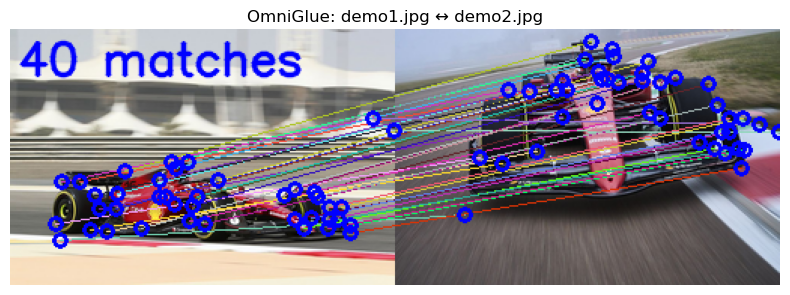

After cleanup - GPU Memory: 21055 MB / 23028 MB (91.4%)
> Memory cleaned up.


In [15]:
# Test with memory tracking
matches, visualization = match_images_with_memory_tracking('./res/demo1.jpg', './res/demo2.jpg')

In [ ]:
# Test with demo images using extreme memory optimization
matches, visualization = match_images_low_memory('./res/demo1.jpg', './res/demo2.jpg')

In [ ]:
# Test with demo images
matches, visualization = match_images_optimized('./res/demo1.jpg', './res/demo2.jpg')

## 7. Test OmniGlue with Custom Images

You can also test OmniGlue with your own images by uploading them to the `test_images` directory.

In [ ]:
# Upload your own images if you want to test with them
# Then match them
# matches, visualization = match_images('test_images/your_image1.jpg', 'test_images/your_image2.jpg')

## 8. Advanced: Test OmniGlue with Custom Parameters

OmniGlue provides options to customize the matching process. Let's create a function that allows us to experiment with different parameters.

In [ ]:
def match_images_custom(image0_path, image1_path, visualize=True, match_threshold=0.02):
    """Perform OmniGlue matching between two images with custom parameters.
    
    Args:
        image0_path: Path to the first image
        image1_path: Path to the second image
        visualize: Whether to visualize the matches
        match_threshold: Threshold for confident matches
        
    Returns:
        matches: Matched keypoints
        visualization: Visualization of the matches if visualize=True
    """
    # Load the images
    image0 = np.array(Image.open(image0_path).convert('RGB'))
    image1 = np.array(Image.open(image1_path).convert('RGB'))
    
    # Create the matcher with custom parameters
    og = omniglue.OmniGlue(
        og_export="./models/og_export",
        sp_export="./models/sp_v6",
        dino_export="./models/dinov2_vitb14_pretrain.pth",
    )
    
    # Match the images
    start_time = time.time()
    match_kp0, match_kp1, match_confidences = og.FindMatches(image0, image1)
    end_time = time.time()
    
    # Filter matches by confidence
    keep_idx = []
    for i in range(match_kp0.shape[0]):
        if match_confidences[i] > match_threshold:
            keep_idx.append(i)
    
    # Apply filtering
    filtered_kp0 = match_kp0[keep_idx]
    filtered_kp1 = match_kp1[keep_idx]
    filtered_confidences = match_confidences[keep_idx]
    # Get stats
    total_matches = match_kp0.shape[0]
    filtered_matches = len(filtered_kp0)
    
    print(f"Total matches found: {total_matches}")
    print(f"Matches with confidence > {match_threshold}: {filtered_matches}")
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    
    if visualize:
        # Create the visualization for filtered matches
        visualization = utils.visualize_matches(
            image0, image1, 
            filtered_kp0, filtered_kp1,
            np.eye(filtered_matches),  # Identity matrix for matches
            show_keypoints=True,
            highlight_unmatched=True,
            title=f"{filtered_matches} filtered matches (threshold: {match_threshold})",
            line_width=2,
        )
        
        # Display the visualization
        plt.figure(figsize=(15, 10))
        plt.imshow(visualization)
        plt.axis('off')
        plt.title(f"OmniGlue filtered matches (threshold: {match_threshold})")
        plt.show()
        
        return filtered_kp0, filtered_kp1, filtered_confidences, visualization
    
    return filtered_kp0, filtered_kp1, filtered_confidences, None

In [ ]:
# Test with custom parameters
filtered_kp0, filtered_kp1, filtered_confidences, visualization = match_images_custom(
    './res/demo1.jpg', './res/demo2.jpg', match_threshold=0.03)

## 9. Compare OmniGlue with Traditional Methods

Let's compare OmniGlue with a traditional method like SIFT to see the difference in matching quality.

In [ ]:
def match_images_sift(image0_path, image1_path, visualize=True, max_keypoints=1024):
    """Perform SIFT matching between two images.
    
    Args:
        image0_path: Path to the first image
        image1_path: Path to the second image
        visualize: Whether to visualize the matches
        max_keypoints: Maximum number of keypoints to detect
        
    Returns:
        matches: Matched keypoints
        visualization: Visualization of the matches if visualize=True
    """
    # Load the images
    image0 = cv2.imread(image0_path)
    image1 = cv2.imread(image1_path)
    
    # Convert to grayscale
    gray0 = cv2.cvtColor(image0, cv2.COLOR_BGR2GRAY)
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    
    # Create SIFT detector
    sift = cv2.SIFT_create(nfeatures=max_keypoints)
    
    # Detect keypoints and compute descriptors
    start_time = time.time()
    kp0, desc0 = sift.detectAndCompute(gray0, None)
    kp1, desc1 = sift.detectAndCompute(gray1, None)
    
    # Match descriptors
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc0, desc1, k=2)
    end_time = time.time()
    
    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    
    print(f"Number of keypoints in image 1: {len(kp0)}")
    print(f"Number of keypoints in image 2: {len(kp1)}")
    print(f"Number of matches: {len(good_matches)}")
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    
    if visualize:
        # Create the visualization
        visualization = cv2.drawMatches(image0, kp0, image1, kp1, good_matches, None,
                                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        
        # Convert BGR to RGB for display
        visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB)
        
        # Display the visualization
        plt.figure(figsize=(15, 10))
        plt.imshow(visualization)
        plt.axis('off')
        plt.title(f"SIFT matches between {os.path.basename(image0_path)} and {os.path.basename(image1_path)}")
        plt.show()
        
        return good_matches, visualization
    
    return good_matches, None

In [ ]:
# Test with SIFT
sift_matches, sift_visualization = match_images_sift('./res/demo1.jpg', './res/demo2.jpg', max_keypoints=1024)

## 10. Conclusion

In this notebook, we've explored OmniGlue, a generalizable image feature matching library from Google Research that leverages foundation models to improve matching across different domains.

We've:
1. Set up the environment and installed OmniGlue
2. Downloaded the required models
3. Tested OmniGlue with demo images
4. Created functions for customized matching
5. Compared OmniGlue with traditional SIFT matching

OmniGlue demonstrates how foundation models can improve traditional computer vision tasks by providing generalizable guidance for feature matching.